In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from common_net import *

In [40]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
opt={}
opt['batch_size']=64
opt['dropout']=0.5
opt['ndres']=32
opt['ndres_gate']=32
opt['ngres']=32
opt['ngres_gate']=32
opt['ngf']=16
opt['ngf_gate']=32
opt['ndf']=16
opt['ndf_gate']=32
opt['out_dim']=1
opt['nz']=10
opt['ngpu']=1
opt['num_samples']=1000000
opt['outf']='./analysis_conv_gated_resnet_resnet_gen_14/'
opt['ndiscrete']=10
opt['ncontinuous']=2
opt['nnoise']=100
opt['latent']=100
opt['n_classes']=10
opt['nsalient']=opt['n_classes']
opt['batchSize']=opt['batch_size']
opt['nc']=1
opt=dotdict(opt)
try:
    os.mkdir(opt.outf)
except OSError:
    pass
print(opt)

{'ngres': 32, 'outf': './analysis_conv_gated_resnet_resnet_gen_14/', 'dropout': 0.5, 'ndiscrete': 10, 'nsalient': 10, 'ngres_gate': 32, 'ndres_gate': 32, 'ndres': 32, 'ngpu': 1, 'batch_size': 64, 'out_dim': 1, 'ngf_gate': 32, 'ndf_gate': 32, 'nnoise': 100, 'ngf': 16, 'latent': 100, 'batchSize': 64, 'nc': 1, 'ndf': 16, 'nz': 10, 'ncontinuous': 2, 'n_classes': 10, 'num_samples': 1000000}


In [8]:
class GatedResnetConvResnetG(nn.Module):
    def __init__(self,opt):
        super(GatedResnetConvResnetG, self).__init__()
        self.opt=opt

        self.label_embedding = nn.Embedding(opt.n_classes, opt.nsalient)
        self.main_initial = nn.Sequential(
          nn.ConvTranspose2d(opt.nnoise, 4*opt.ngf, 1, 1, bias=False),
          nn.BatchNorm2d(4*opt.ngf),
          nn.ReLU(True),
          nn.ConvTranspose2d(4*opt.ngf, 2*opt.ngf, 7, 1, bias=False),
          nn.BatchNorm2d(2*opt.ngf),
          nn.ReLU(True),
          nn.ConvTranspose2d(2*opt.ngf, 2*opt.ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(2*opt.ngf),
          nn.ReLU(True),
          nn.ConvTranspose2d(2*opt.ngf, opt.ngf, 4, 2, 1, bias=False),
          #nn.Sigmoid()
        )

        main_block=[]
        #Input is z going to series of rsidual blocks

        # Sets of residual blocks start

        for i in range(opt.ngres):
            main_block+= [GatedConvResBlock(opt.ngf,opt.ngf,dropout=opt.dropout)] #[BATCHResBlock(opt.ngf,opt.dropout)]


        # Final layer to map to 1 channel

        main_block+=[nn.Conv2d(opt.ngf,opt.nc,kernel_size=3,stride=1,padding=1)]
        main_block+=[nn.Tanh()]
        self.main=nn.Sequential(*main_block)

        gate_block =[]
        gate_block+=[ nn.Linear(opt.nsalient ,opt.ngf_gate)]
        #gate_block+=[ nn.BatchNorm1d(opt.ngf_gate) ]
        gate_block+=[ nn.ReLU()]
        for i in range(opt.ngres_gate):
            gate_block+=[ResBlock(opt.ngf_gate,opt.dropout)]
        gate_block+=[ nn.Linear(opt.ngf_gate,opt.ngres) ]
        gate_block+= [ nn.Sigmoid()]# [nn.Softmax()]  #[ nn.Sigmoid()]

        self.gate=nn.Sequential(*gate_block)

    def forward(self, noise , labels):
        input_gate = self.label_embedding(labels)
        input_main = noise
        input_main = input_main.resize(self.opt.batchSize,self.opt.nnoise,1,1)

        output_gate = self.gate(input_gate)
        output = self.main_initial(input_main)
        for i in range(self.opt.ngres):
            alpha = output_gate[:,i]
            alpha = alpha.resize(self.opt.batchSize,1,1,1)
            output=self.main[i](output,alpha)

        output=self.main[self.opt.ngres](output)
        output=self.main[self.opt.ngres+1](output)
        return output

In [9]:
class GatedResnetConvResnetD(nn.Module):
    def __init__(self,opt):
        super(GatedResnetConvResnetD, self).__init__()
        self.opt=opt

        self.label_embedding = nn.Embedding(opt.n_classes, opt.nsalient)
        self.main_latter = nn.Sequential(
        nn.Conv2d(opt.ndf, opt.ndf, 4, 2, 1),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(opt.ndf, 2*opt.ndf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(2*opt.ndf),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(2*opt.ndf, 2*opt.ndf, 7, bias=False),
        nn.BatchNorm2d(2*opt.ndf),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(2*opt.ndf, 1, 1),
        nn.Sigmoid()
        )


        main_block=[]
        #Input is z going to series of rsidual blocks
        # First layer to map to ndf channel

        main_block+=[nn.Conv2d(opt.nc,opt.ndf,kernel_size=3,stride=1,padding=1)]

        # Sets of residual blocks start

        for i in range(opt.ndres):
            main_block+= [GatedConvResBlock(opt.ndf,opt.ndf,dropout=opt.dropout)] #[BATCHResBlock(opt.ngf,opt.dropout)]


        self.main=nn.Sequential(*main_block)

        gate_block =[]
        gate_block+=[ nn.Linear(opt.nsalient ,opt.ndf_gate)]
        #gate_block+=[ nn.BatchNorm1d(opt.ngf_gate) ]
        gate_block+=[ nn.ReLU()]
        for i in range(opt.ndres_gate):
            gate_block+=[ResBlock(opt.ndf_gate,opt.dropout)]
        gate_block+=[ nn.Linear(opt.ndf_gate,opt.ndres) ]
        gate_block+= [nn.Sigmoid()] #[nn.Softmax()]  #[ nn.Sigmoid()]

        self.gate=nn.Sequential(*gate_block)

    def forward(self, img, labels):
        input_gate = self.label_embedding(labels)
        input_main = img

        output_gate = self.gate(input_gate)
        output = self.main[0](img)
        for i in xrange(1,1+self.opt.ndres):
            alpha = output_gate[:,i-1]
            alpha = alpha.resize(self.opt.batchSize,1,1,1)
            output=self.main[i](output,alpha)

        output = self.main_latter(output)
        return output

In [107]:
print(opt)
generator = GatedResnetConvResnetG(opt)
generator.cuda()
generator.eval()

discriminator=GatedResnetConvResnetD(opt)
discriminator.cuda()
discriminator.eval()
#load generator
gen_path='conv_gated_resnet_resnet_gen_14/netG_epoch_19200.pth'
generator.load_state_dict(torch.load(gen_path))

dis_path='conv_gated_resnet_resnet_gen_14/netD_epoch_19200.pth'
discriminator.load_state_dict(torch.load(dis_path))

{'ngres': 32, 'outf': './analysis_conv_gated_resnet_resnet_gen_14/', 'dropout': 0.5, 'ndiscrete': 10, 'nsalient': 10, 'ngres_gate': 32, 'ndres_gate': 32, 'ndres': 32, 'ngpu': 1, 'batch_size': 64, 'out_dim': 1, 'ngf_gate': 32, 'ndf_gate': 32, 'nnoise': 100, 'ngf': 16, 'latent': 100, 'batchSize': 64, 'nc': 1, 'ndf': 16, 'nz': 10, 'ncontinuous': 2, 'n_classes': 10, 'num_samples': 1000000}


In [47]:
FloatTensor = torch.cuda.FloatTensor 
LongTensor = torch.cuda.LongTensor 

# Sample noise
n_row=8
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row**2, opt.latent))))
# Get labels ranging from 0 to n_classes for n rows
cur_id = 0
labels = np.array([cur_id for _ in range(n_row) for num in range(n_row)])
labels = Variable(LongTensor(labels))

In [50]:
print(labels)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')


In [94]:
def d_get_output_gate_np(cur_id):
    labels = np.array([cur_id for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    input_gate = discriminator.label_embedding(labels)
    output_gate = discriminator.gate(input_gate)
    output_gate_np = output_gate.data.cpu().numpy()
    return output_gate_np

In [95]:
def g_get_output_gate_np(cur_id):
    labels = np.array([cur_id for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    input_gate = generator.label_embedding(labels)
    output_gate = generator.gate(input_gate)
    output_gate_np = output_gate.data.cpu().numpy()
    return output_gate_np

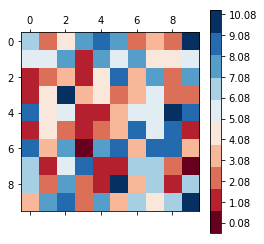

In [75]:
import matplotlib.pyplot as plt
import numpy as np

def discrete_matshow(data):
    #get discrete colormap
    cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap,vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

#generate data
a=10*np.random.uniform(0, 1, size=(10, 10))
discrete_matshow(a)

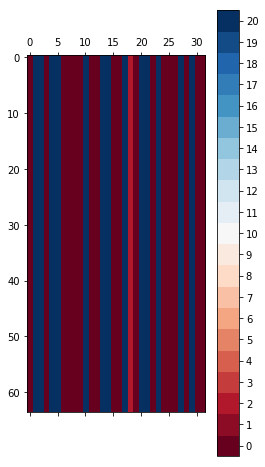

In [108]:
discrete_matshow(d_get_output_gate_np(0)*20)

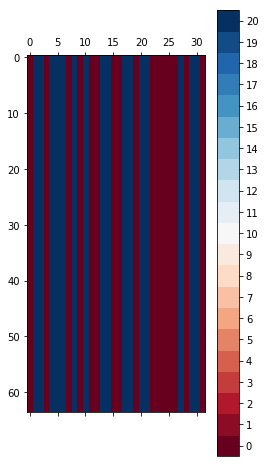

In [109]:
discrete_matshow(d_get_output_gate_np(1)*20)

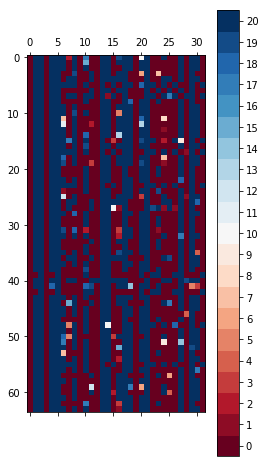

In [98]:
discrete_matshow(d_get_output_gate_np(2)*20)

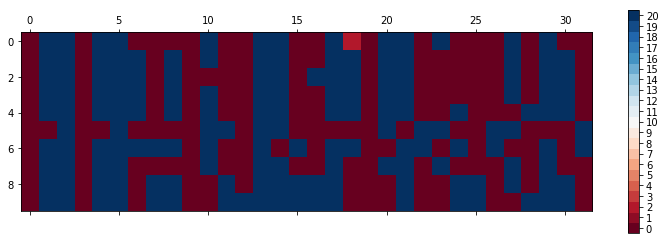

In [110]:
output_gates=np.zeros((10,32))
for i in range(10):
    output_gate_np = d_get_output_gate_np(i) * 20
    output_gates[i]=output_gate_np.mean(axis=0)
    
discrete_matshow(output_gates)    

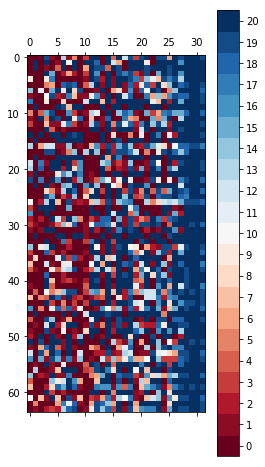

In [102]:
discrete_matshow(g_get_output_gate_np(0)*20)

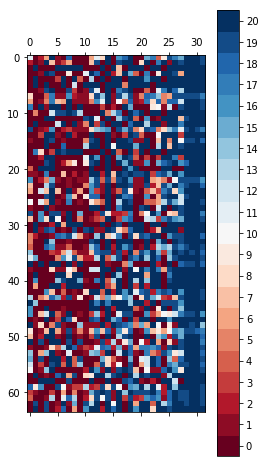

In [104]:
discrete_matshow(g_get_output_gate_np(1)*20)

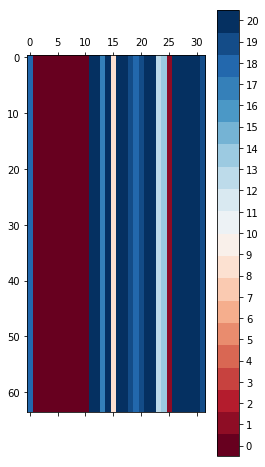

In [112]:
discrete_matshow(g_get_output_gate_np(2)*20)

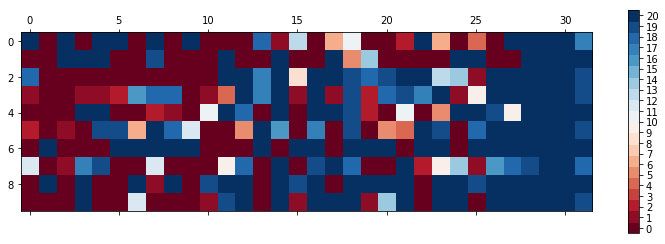

In [111]:
output_gates=np.zeros((10,32))
for i in range(10):
    output_gate_np = g_get_output_gate_np(i) * 20
    output_gates[i]=output_gate_np.mean(axis=0)
    
discrete_matshow(output_gates)  

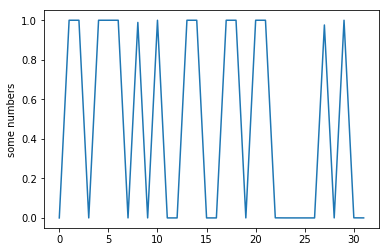

In [71]:
import matplotlib.pyplot as plt
plt.plot(output_gate_np[45])
plt.ylabel('some numbers')
plt.show()

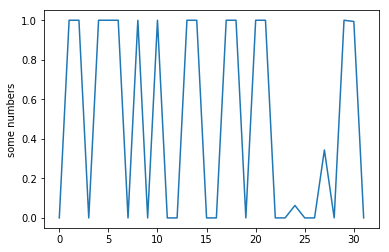

In [72]:
plt.plot(output_gate_np[0])
plt.ylabel('some numbers')
plt.show()